<a href="https://www.kaggle.com/code/ousoka/ppd-v1?scriptVersionId=231957275" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from glob import glob
import random
from PIL import Image
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
mixed_precision.set_global_policy("mixed_float16")  # Speed up training on GPU


TensorFlow Version: 2.17.1
Num GPUs Available: 1


# EDA

In [2]:
import os
import pandas as pd

# Dataset directory path
directory_path = "/kaggle/input/ppd-v3/ppd_v3"

# Dictionary to store class names and image counts
class_counts = {}

# Iterate over each class folder
for class_name in os.listdir(directory_path):
    class_path = os.path.join(directory_path, class_name)
    if os.path.isdir(class_path):  # Ensure it's a folder
        image_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        class_counts[class_name] = image_count

# Convert to DataFrame for better visualization
df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])

# Display results
print(df)

                    Class  Image Count
0        aphis craccivora          411
1           beet armyworm          455
2                   mites          443
3             grasshopper          462
4           Thrips tabaci          450
5       Spodoptera litura          449
6          Empoasca fabae          463
7     Tetranychus urticae          389
8            catterpillar          474
9   Schistocerca gregaria          478
10                 weevil          470
11                 aphids          389
12   Helicoverpa armigera          450


## Summary Statistics

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display basic statistics
print(df.describe())


       Image Count
count    13.000000
mean    444.846154
std      29.952313
min     389.000000
25%     443.000000
50%     450.000000
75%     463.000000
max     478.000000


## Distribution of Image Counts

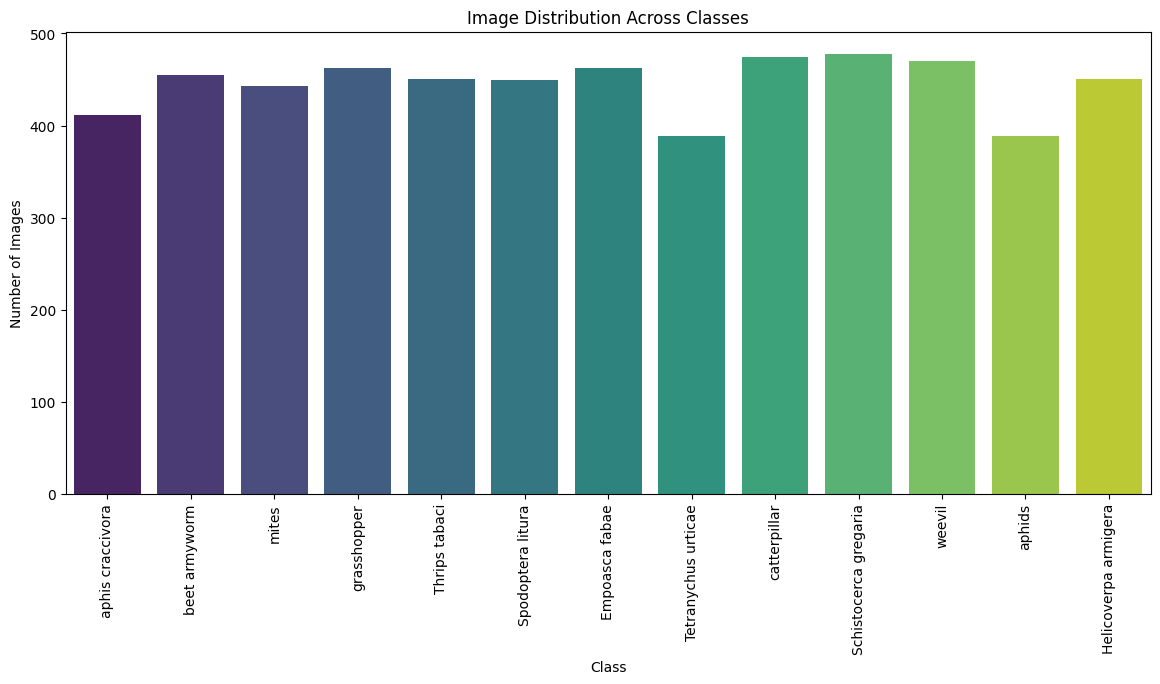

In [4]:
# Set plot size
plt.figure(figsize=(14, 6))

# Bar plot of class distributions
sns.barplot(x="Class", y="Image Count", data=df, palette="viridis")

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Labels and title
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Image Distribution Across Classes")

# Show the plot
plt.show()


## Check All Image Extensions in the Dataset

In [5]:
# Set to store unique file extensions
unique_extensions = set()

# Loop through each class folder
for pest_class in os.listdir(directory_path):
    class_dir = os.path.join(directory_path, pest_class)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        for file in os.listdir(class_dir):
            ext = os.path.splitext(file)[1].lower()  # Extract file extension
            if ext:  # Ensure there's an extension
                unique_extensions.add(ext)

# Display all unique extensions found
print("📌 Unique file extensions in the dataset:", unique_extensions)

📌 Unique file extensions in the dataset: {'.jpg'}


## Display 2 Images Per Class

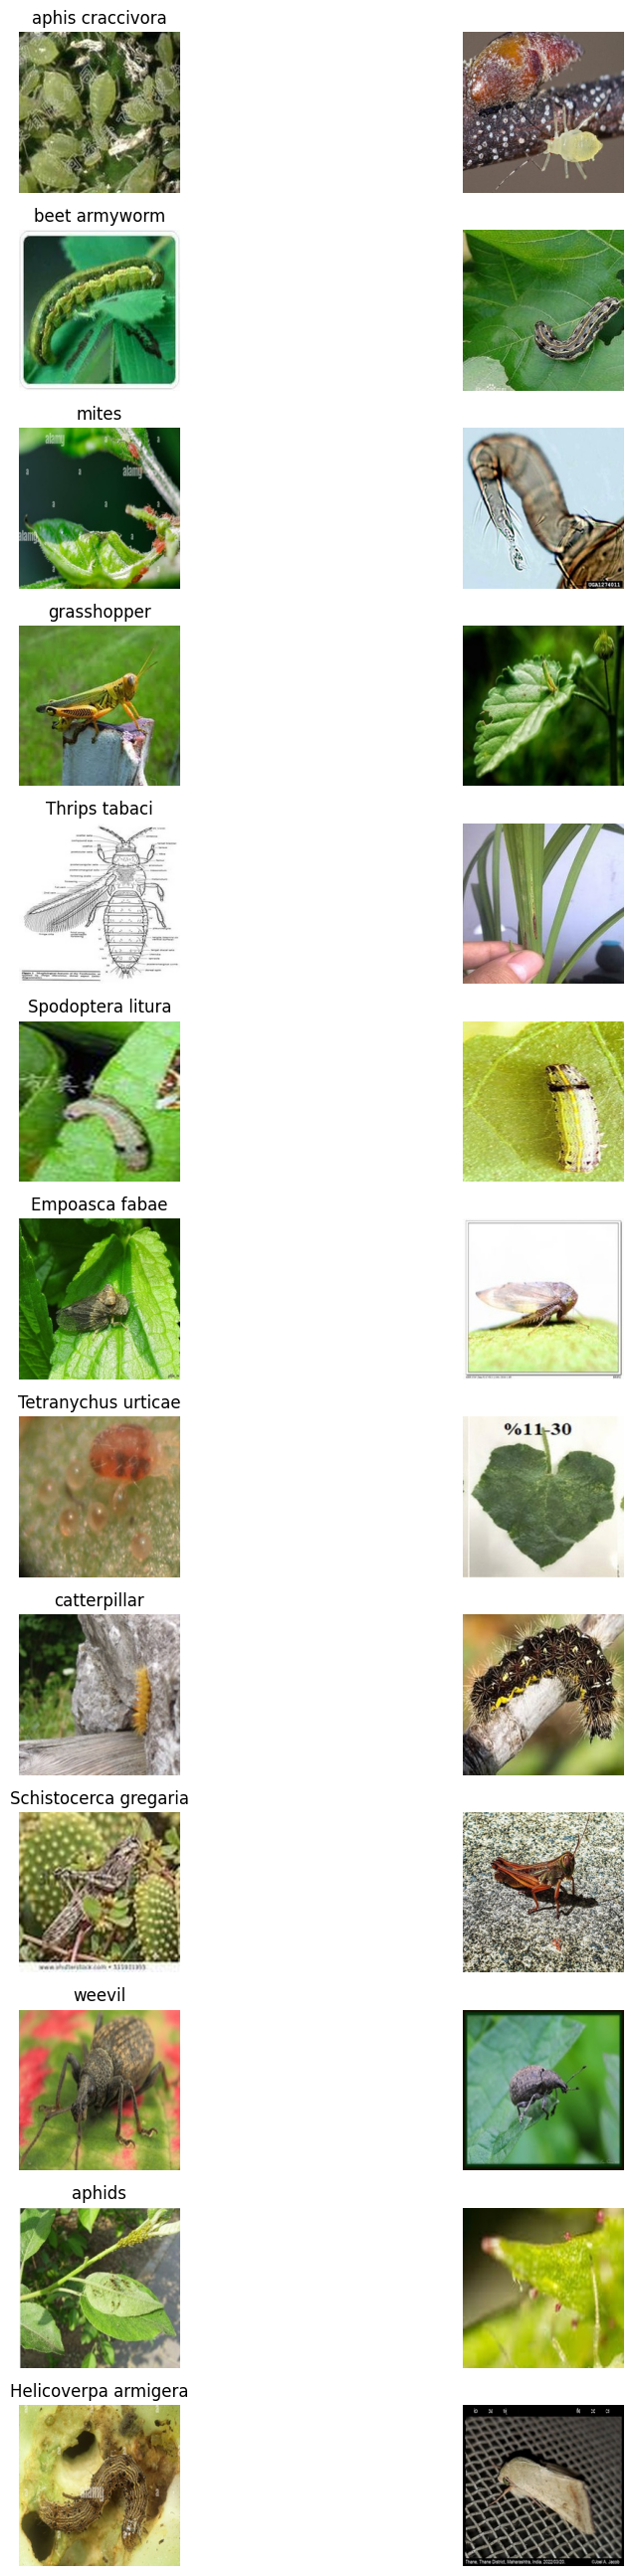

In [6]:
import os
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np

# Dataset directory
directory_path = "/kaggle/input/ppd-v3/ppd_v3"

# Number of samples per class
samples_per_class = 2

# Get all class names
class_names = [name for name in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, name))]

# Define number of rows and columns
num_rows = len(class_names)
num_cols = samples_per_class

# Set figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 2))

# Iterate over each class
for row_idx, class_name in enumerate(class_names):
    class_path = os.path.join(directory_path, class_name)
    
    # Get all images in the class directory
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    # Select 2 random images
    selected_images = random.sample(image_files, min(samples_per_class, len(image_files)))
    
    # Display images
    for col_idx, image_file in enumerate(selected_images):
        img_path = os.path.join(class_path, image_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        ax = axes[row_idx, col_idx]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(class_name if col_idx == 0 else "")

# Add separation lines
for row in range(num_rows - 1):  # Horizontal lines
    plt.axhline(y=row + 0.5, color='black', linewidth=2, linestyle="--")

for col in range(num_cols - 1):  # Vertical lines
    plt.axvline(x=col + 0.5, color='black', linewidth=2, linestyle="--")

plt.tight_layout()
plt.show()


## Overlooking on the Dataset

In [7]:
pest_classes = os.listdir(directory_path)
print(f"📌 Found {len(pest_classes)} classes: {pest_classes}")


📌 Found 13 classes: ['aphis craccivora', 'beet armyworm', 'mites', 'grasshopper', 'Thrips tabaci', 'Spodoptera litura', 'Empoasca fabae', 'Tetranychus urticae', 'catterpillar', 'Schistocerca gregaria', 'weevil', 'aphids', 'Helicoverpa armigera']


In [8]:
VALID_EXTENSIONS = {".jpg", ".jpeg", ".png", ".webp", ".jfif", ".gif"}  # Valid image formats

# Dictionary to store image counts per class
image_counts = {}

# Loop through each class folder
for pest_class in os.listdir(directory_path):
    class_dir = os.path.join(directory_path, pest_class)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        num_images = sum(
            len(glob(os.path.join(class_dir, f"*{ext}"))) for ext in VALID_EXTENSIONS
        )
        image_counts[pest_class] = num_images

# Convert to DataFrame for better visualization
df_counts = pd.DataFrame(image_counts.items(), columns=["Class", "Image Count"])

# Display total images in the dataset
total_images = df_counts["Image Count"].sum()
print(f"📌 Total images in dataset: {total_images}")
df_counts

📌 Total images in dataset: 5763


Class  Image Count
0        aphis craccivora          411
1           beet armyworm          455
2                   mites          441
3             grasshopper          462
4           Thrips tabaci          449
5       Spodoptera litura          449
6          Empoasca fabae          463
7     Tetranychus urticae          387
8            catterpillar          474
9   Schistocerca gregaria          478
10                 weevil          470
11                 aphids          385
12   Helicoverpa armigera          439

# **DL model to do the automatic pest detection**

## Pest classification using an EfficientNetV2 model
Since each image contain one kind of pest, we will try using classification with EfficientNetV2

In [9]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras import preprocessing
# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='darkgrid')

In [10]:
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # For TensorFlow 2.x, use these settings for deterministic behavior
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
    
    # Set global determinism for CUDA operations if using GPU
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # Set thread determinism if you need multiprocessing
    # Note: This may impact performance
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

In [11]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2025-04-04 22:31:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-04-04 22:31:26 (19.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [12]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [13]:
# Walk through each directory
dataset = "/kaggle/input/ppd-v3/ppd_v3"
walk_through_dir(dataset)

There are 13 directories and 0 images in '/kaggle/input/ppd-v3/ppd_v3'.
There are 0 directories and 411 images in '/kaggle/input/ppd-v3/ppd_v3/aphis craccivora'.
There are 0 directories and 455 images in '/kaggle/input/ppd-v3/ppd_v3/beet armyworm'.
There are 0 directories and 443 images in '/kaggle/input/ppd-v3/ppd_v3/mites'.
There are 0 directories and 462 images in '/kaggle/input/ppd-v3/ppd_v3/grasshopper'.
There are 0 directories and 450 images in '/kaggle/input/ppd-v3/ppd_v3/Thrips tabaci'.
There are 0 directories and 449 images in '/kaggle/input/ppd-v3/ppd_v3/Spodoptera litura'.
There are 0 directories and 463 images in '/kaggle/input/ppd-v3/ppd_v3/Empoasca fabae'.
There are 0 directories and 389 images in '/kaggle/input/ppd-v3/ppd_v3/Tetranychus urticae'.
There are 0 directories and 474 images in '/kaggle/input/ppd-v3/ppd_v3/catterpillar'.
There are 0 directories and 478 images in '/kaggle/input/ppd-v3/ppd_v3/Schistocerca gregaria'.
There are 0 directories and 470 images in '/kag

In [14]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)
    
    # List of all extensions to search for (in both lowercase and uppercase)
    extensions = ['.png', '.gif', '.jfif', '.jpg', '.webp', '.jpeg']
    extensions += [ext.upper() for ext in extensions]
    
    # Get filepaths for all specified extensions
    filepaths = []
    for ext in extensions:
        filepaths.extend(list(image_dir.glob(f'**/*{ext}')))
    
    # If no images found, return empty DataFrame
    if not filepaths:
        return pd.DataFrame(columns=['Filepath', 'Label'])
    
    # Extract labels from directory structure
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    
    # Convert to Series
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    
    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    
    return image_df

In [15]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

# List of all extensions to check
extensions = ['.png', '.gif', '.jfif', '.jpg', '.webp', '.jpeg']
extensions += [ext.upper() for ext in extensions]

corrupted_images = []
base_path = Path("/kaggle/input/ppd-v3/ppd_v3")

# Check each extension
for ext in extensions:
    path = base_path.rglob(f"*{ext}")
    for img_p in path:
        try:
            img = PIL.Image.open(img_p)
            # Optional: verify the image by loading it
            img.verify()
        except (PIL.UnidentifiedImageError, PIL.Image.DecompressionBombError, OSError, ValueError) as e:
            print(f"Corrupted image: {img_p} - Error: {e}")
            corrupted_images.append(img_p)

print(f"Total corrupted images found: {len(corrupted_images)}")

Total corrupted images found: 0


In [16]:
image_df = convert_path_to_df(dataset)


In [17]:

# Define labels to exclude
excluded_labels = ['mites', 'Tetranychus urticae', 'caterpillar', 'aphids']

# Filter out the excluded labels
image_df = image_df[~image_df['Label'].isin(excluded_labels)]


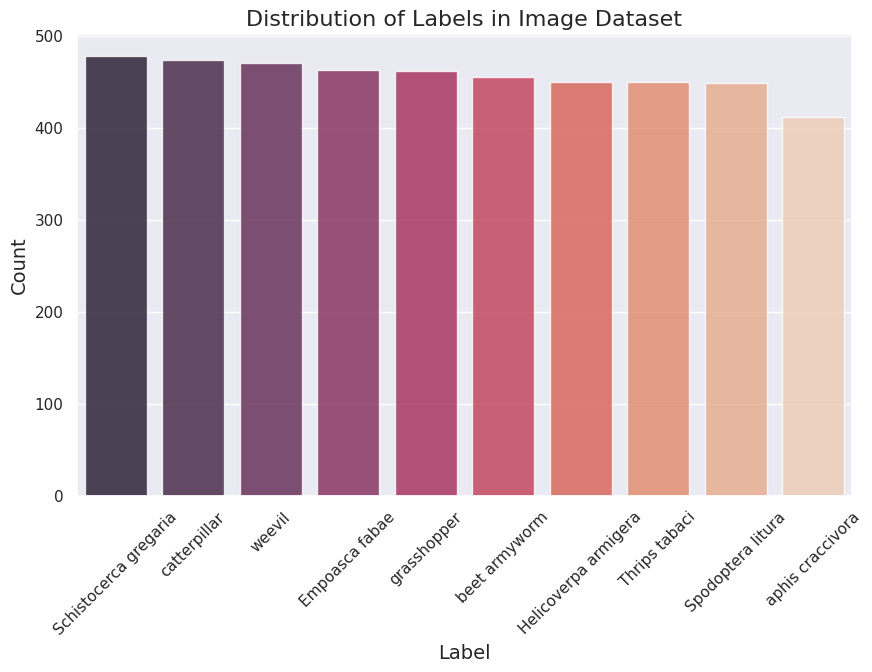

In [18]:
label_counts = image_df['Label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45) 
plt.show()


In [19]:
len(image_df)

4562

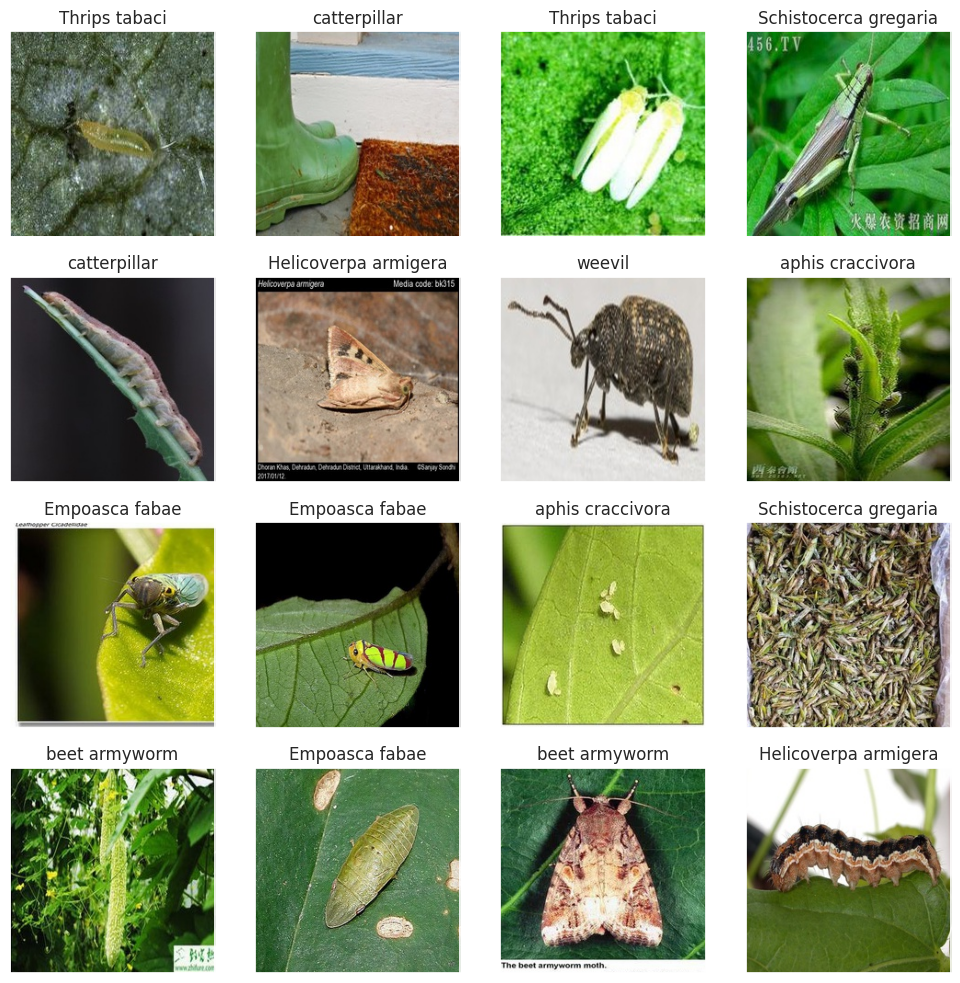

In [20]:

# Générer de nouveaux indices aléatoires après filtrage
random_index = np.random.choice(len(image_df), 16, replace=False)

# Affichage des images
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath.iloc[random_index[i]]))  # Utiliser `.iloc` pour éviter les erreurs d'index
    ax.set_title(image_df.Label.iloc[random_index[i]])

plt.tight_layout()
plt.show()

In [21]:
def compute_ela_cv(path, quality):
    """
    Compute Error Level Analysis using OpenCV
    
    Args:
        path: Path to the input image
        quality: JPEG compression quality (0-100)
    
    Returns:
        Difference image highlighting compression artifacts
    """
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    
    # Handle different file formats
    try:
        orig_img = cv2.imread(path)
        if orig_img is None:
            raise ValueError(f"Failed to load image: {path}")
        
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        
        cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

        # Read compressed image
        compressed_img = cv2.imread(temp_filename)

        # Get absolute difference between img1 and img2 and multiply by scale
        diff = SCALE * cv2.absdiff(orig_img, compressed_img)
        
        # Clean up temp file
        if os.path.exists(temp_filename):
            os.remove(temp_filename)
            
        return diff
    
    except Exception as e:
        print(f"Error processing {path}: {e}")
        # Return a blank image of the same size
        if 'orig_img' in locals() and orig_img is not None:
            return np.zeros_like(orig_img)
        return None


def convert_to_ela_image(path, quality):
    """
    Convert image to Error Level Analysis image using PIL
    
    Args:
        path: Path to the input image
        quality: JPEG compression quality (0-100)
    
    Returns:
        PIL Image showing ELA result
    """
    temp_filename = 'temp_file_name.jpeg'
    
    try:
        # Open and convert to RGB (handles different formats)
        image = Image.open(path).convert('RGB')
        image.save(temp_filename, 'JPEG', quality=quality)
        temp_image = Image.open(temp_filename)

        ela_image = ImageChops.difference(image, temp_image)

        extrema = ela_image.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        if max_diff == 0:
            max_diff = 1

        scale = 255.0 / max_diff
        ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
        
        # Clean up temp file
        if os.path.exists(temp_filename):
            os.remove(temp_filename)
            
        return ela_image
    
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None


def random_sample(path, extensions=None):
    """
    Get a random sample image from a directory
    
    Args:
        path: Directory path to search
        extensions: List of file extensions to include, or None for all files
    
    Returns:
        String path to a randomly selected file
    """
    if extensions is None:
        # Default to all your image formats
        extensions = ['png', 'gif', 'jfif', 'jpg', 'webp', 'jpeg', 
                      'PNG', 'GIF', 'JFIF', 'JPG', 'WEBP', 'JPEG']
    
    items = []
    
    # If extensions is a list, iterate through each extension
    if isinstance(extensions, list):
        for ext in extensions:
            items.extend(list(Path(path).glob(f'*.{ext}')))
    # If extensions is a single string, use it directly
    elif extensions:
        items = list(Path(path).glob(f'*.{extensions}'))
    # If no extensions specified, get all files
    else:
        items = list(Path(path).glob('*'))
    
    # Check if we found any files
    if not items:
        raise ValueError(f"No files found in {path} with extensions {extensions}")
        
    p = random.choice(items)
    return p.as_posix()

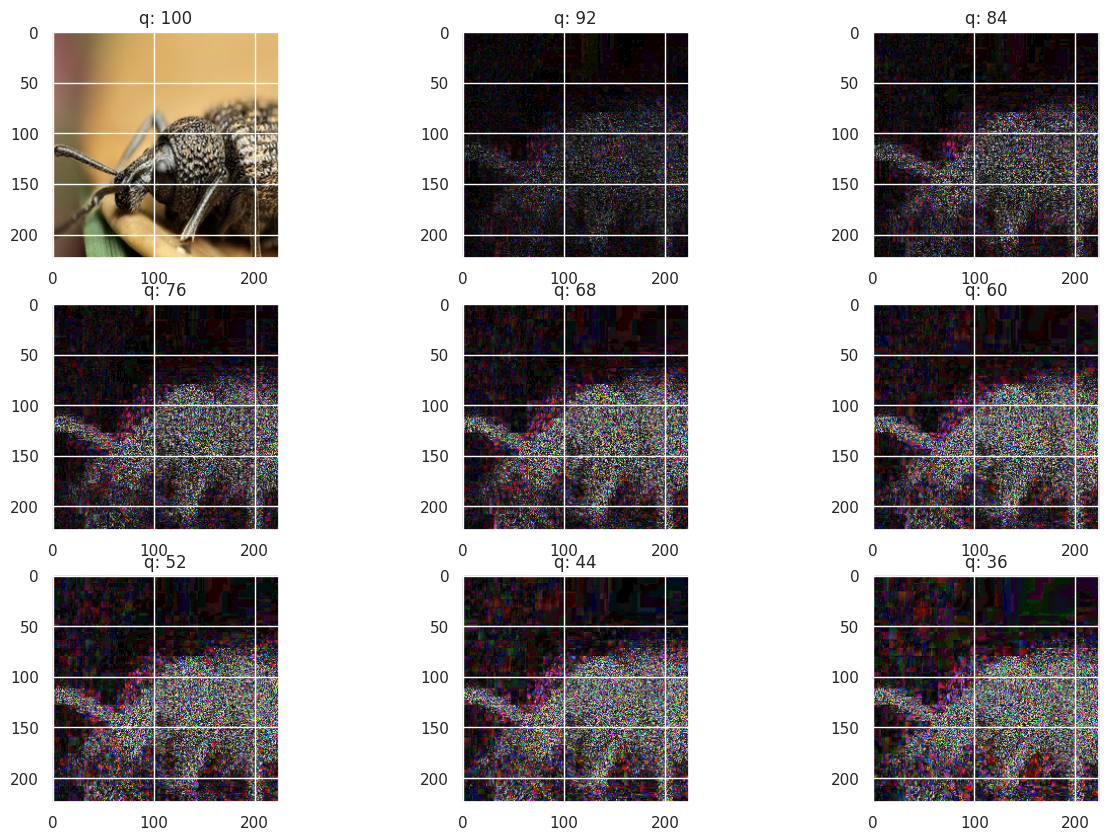

In [22]:
# View random sample from the dataset
p = random_sample('/kaggle/input/ppd-v3/ppd_v3/weevil')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [23]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [24]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

In [25]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2920 validated image filenames belonging to 10 classes.
Found 729 validated image filenames belonging to 10 classes.
Found 913 validated image filenames belonging to 10 classes.


In [26]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  tf.keras.layers.Resizing(224, 224),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomContrast(0.1),
])

In [27]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [28]:
# Create checkpoint callback
checkpoint_path = "peanut_pests_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                     save_weights_only=True,
                                     monitor="val_accuracy",
                                     save_best_only=True)

In [29]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [30]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# inputs = pretrained_model.input
# x = augment(inputs)

# x = Dense(128, activation='relu')(pretrained_model.output)
# x = Dropout(0.45)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.45)(x)


# outputs = Dense(10, activation='softmax')(x)

# model = Model(inputs=inputs, outputs=outputs)

# model.compile(
#     optimizer=Adam(0.00001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # history = model.fit(
# #     train_images,
# #     steps_per_epoch=len(train_images),
# #     validation_data=val_images,
# #     validation_steps=len(val_images),
# #     epochs=100,
# #     callbacks=[
# #         early_stopping,
# #         create_tensorboard_callback("training_logs", 
# #                                     "peanut_pests_classification"),
# #         checkpoint_callback,
# #     ]
# # )

# history = model.fit(
#     train_images,
#     steps_per_epoch=len(train_images),
#     validation_data=val_images,
#     validation_steps=len(val_images),
#     epochs=100,
#     callbacks=[early_stopping, checkpoint_callback]  # Start with just one callback
# )

In [31]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# # Keep your base pretrained model and augmentation
# inputs = pretrained_model.input
# x = augment(inputs)

# # Skip the GlobalAveragePooling2D since output is already 2D
# # Start directly with the first dense layer
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# # Second dense block with batch normalization and reduced dropout
# x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# outputs = Dense(10, activation='softmax')(x)

# model = Model(inputs=inputs, outputs=outputs)

# # Use a learning rate scheduler
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# # Compile with a slightly higher initial learning rate
# model.compile(
#     optimizer=Adam(0.0001),  # Increased from 0.00001
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Add the learning rate scheduler to your callbacks
# history = model.fit(
#     train_images,
#     steps_per_epoch=len(train_images),
#     validation_data=val_images,
#     validation_steps=len(val_images),
#     epochs=10,
#     callbacks=[early_stopping, checkpoint_callback, reduce_lr]
# )

In [32]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# # Entrée depuis le modèle pré-entraîné
# inputs = pretrained_model.input
# x = augment(inputs)

# # Vérifier si GlobalAveragePooling2D est nécessaire
# if len(pretrained_model.output.shape) == 4:  # Vérifie si la sortie est en 4D
#     x = GlobalAveragePooling2D()(pretrained_model.output)
# else:
#     x = pretrained_model.output  # Utiliser directement la sortie s'il est déjà en 2D

# # Premier bloc dense avec plus de neurones
# x = Dense(512, activation='relu', kernel_regularizer=l2(0.0005))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x)

# # Deuxième bloc dense
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# # Couche de sortie
# outputs = Dense(10, activation='softmax')(x)

# # Création du modèle
# model = Model(inputs=inputs, outputs=outputs)

# from tensorflow.keras.callbacks import LearningRateScheduler

# # Définition du scheduler exponentiel
# def lr_schedule(epoch, lr):
#     return lr * 0.9 if epoch > 3 else lr  # Réduction progressive après 3 epochs

# lr_scheduler = LearningRateScheduler(lr_schedule)

# model.compile(
#     optimizer=Adam(learning_rate=0.0003),  # Augmenté pour accélérer l'apprentissage
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# history = model.fit(
#     train_images,
#     validation_data=val_images,
#     epochs=20,
#     callbacks=[checkpoint_callback, lr_scheduler]
# )
